In [1]:
from dotenv import load_dotenv
load_dotenv()

True

In [2]:
# LangSmith 추적을 설정합니다. https://smith.langchain.com
# !pip install -qU langchain-teddynote
from langchain_teddynote import logging

# 프로젝트 이름을 입력합니다.
logging.langsmith("Langgraph")

LangSmith 추적을 시작합니다.
[프로젝트명]
Langgraph


In [4]:
import pickle

In [6]:
from langchain_community.vectorstores import FAISS
from langchain.retrievers import BM25Retriever, EnsembleRetriever
from langchain_openai import OpenAIEmbeddings

In [5]:
with open("results/split_documents.pkl", "rb") as f:
    split_documents = pickle.load(f)

In [7]:
vectorstore = FAISS.load_local(
    "faiss_index", 
    OpenAIEmbeddings(),
    allow_dangerous_deserialization=True  # needed in newer versions
)
faiss_retriever = vectorstore.as_retriever(search_kwargs={"k": 1})
bm25_retriever = BM25Retriever.from_documents(
    split_documents,
)
bm25_retriever.k = 1
ensemble_retriever = EnsembleRetriever(
    retrievers=[bm25_retriever, faiss_retriever],
    weights=[0.7, 0.3],
)

In [3]:
from typing import Annotated, TypedDict
from langgraph.graph.message import add_messages


# GraphState 상태 정의
class GraphState(TypedDict):
    question: Annotated[str, "Question"]  # 질문
    context: Annotated[str, "Context"]  # 문서의 검색 결과
    answer: Annotated[str, "Answer"]  # 답변
    messages: Annotated[list, add_messages]  # 메시지(누적되는 list)
    relevance: Annotated[str, "Relevance"]  # 관련성

In [8]:
from langchain.schema import format_document
from langchain_openai import ChatOpenAI
from langchain_teddynote.evaluator import GroundednessChecker
from langchain_teddynote.messages import messages_to_history
from utils import format_context

llm = ChatOpenAI(model="gpt-5-nano", temperature=0)

# 문서 검색 노드
def retrieve_document(state: GraphState) -> GraphState:
    # 질문을 상태에서 가져옵니다.
    latest_question = state["question"]

    # 문서에서 검색하여 관련성 있는 문서를 찾습니다.
    retrieved_docs = ensemble_retriever.invoke(latest_question)

    # 검색된 문서를 형식화합니다.(프롬프트 입력으로 넣어주기 위함)
    retrieved_docs = format_context(retrieved_docs)

    # 검색된 문서를 context 키에 저장합니다.
    return GraphState(context=retrieved_docs)


# 답변 생성 노드
def llm_answer(state: GraphState) -> GraphState:
    # 질문을 상태에서 가져옵니다.
    latest_question = state["question"]

    # 검색된 문서를 상태에서 가져옵니다.
    context = state["context"]

    system_prompt = """You are an assistant for question-answering tasks. 
        Use the following pieces of retrieved context to answer the question. 
        If you don't know the answer, just say that you don't know. 
        Answer in Korean.
    """
    
    prompt = [
        {"role": "system", "content": system_prompt},
        {"role": "user", "content": "Context: " + context},
        {"role": "user", "content": "Question: " + latest_question},
    ]
        
    # 체인을 호출하여 답변을 생성합니다.
    response = llm.invoke(prompt)
    return {
        "answer": response.content,
        "messages": [("user", latest_question), ("assistant", response.content)],
    }

# 관련성 체크 노드
def relevance_check(state: GraphState) -> GraphState:
    # 관련성 평가기를 생성합니다.
    question_retrieval_relevant = GroundednessChecker(
        llm=ChatOpenAI(model="gpt-5-nano", temperature=0), target="question-retrieval"
    ).create()

    # 관련성 체크를 실행("yes" or "no")
    response = question_retrieval_relevant.invoke(
        {"question": state["question"], "context": state["context"]}
    )

    print("==== [RELEVANCE CHECK] ====")
    print(response.score)

    # 참고: 여기서의 관련성 평가기는 각자의 Prompt 를 사용하여 수정할 수 있습니다. 여러분들의 Groundedness Check 를 만들어 사용해 보세요!
    return {"relevance": response.score}


def is_relevant(state: GraphState) -> GraphState:
    if state["relevance"] == "yes":
        return "relevant"
    else:
        return "not relevant"

In [9]:
from langgraph.graph import END, StateGraph
from langgraph.checkpoint.memory import MemorySaver

# 그래프 정의
workflow = StateGraph(GraphState)

# 노드 추가
workflow.add_node("retrieve", retrieve_document)
# 관련성 체크 노드 추가
workflow.add_node("relevance_check", relevance_check)
workflow.add_node("llm_answer", llm_answer)

# 엣지 추가
workflow.add_edge("retrieve", "relevance_check")  # 검색 -> 관련성 체크


# 조건부 엣지를 추가합니다.
workflow.add_conditional_edges(
    "relevance_check",  # 관련성 체크 노드에서 나온 결과를 is_relevant 함수에 전달합니다.
    is_relevant,
    {
        "relevant": "llm_answer",  # 관련성이 있으면 답변을 생성합니다.
        "not relevant": "retrieve",  # 관련성이 없으면 다시 검색합니다.
    },
)

workflow.add_edge("llm_answer", END)

# 그래프 진입점 설정
workflow.set_entry_point("retrieve")

# 체크포인터 설정
memory = MemorySaver()

# 그래프 컴파일
app = workflow.compile(checkpointer=memory)

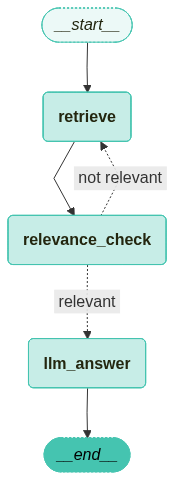

In [10]:
from langchain_teddynote.graphs import visualize_graph

# 그래프 시각화
visualize_graph(app)

In [17]:
from langchain_core.runnables import RunnableConfig
from langchain_teddynote.messages import stream_graph, invoke_graph, random_uuid

# config 설정(재귀 최대 횟수, thread_id)
config = RunnableConfig(recursion_limit=5, configurable={"thread_id": random_uuid()})

# 질문 입력
inputs = GraphState(question="해왕성의의 경제 위협은 무엇이야?")



In [ ]:
# 그래프 실행
invoke_graph(app, inputs, config, node_names=["relevance_check", "llm_answer"])

In [18]:
# 그래프 스트리밍 출력
stream_graph(app, inputs, config, node_names=["relevance_check", "llm_answer"])


🔄 Node: relevance_check 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
{"score":"no"}==== [RELEVANCE CHECK] ====
no
{"score":"no"}==== [RELEVANCE CHECK] ====
no


GraphRecursionError: Recursion limit of 5 reached without hitting a stop condition. You can increase the limit by setting the `recursion_limit` config key.
For troubleshooting, visit: https://python.langchain.com/docs/troubleshooting/errors/GRAPH_RECURSION_LIMIT

In [15]:
outputs = app.get_state(config).values

print(f'Question: {outputs["question"]}')
print("===" * 20)
print(f'Answer:\n{outputs["answer"]}')

Question: 터키의 경제 위협은 무엇이야?
Answer:
터키의 주요 경제 위협은 다음과 같습니다:

- 2024년에 아주 높은 인플레이션이 나타났고(약 60%), 2025년에도 약 33.5%, 2026년 약 18.9%로 여전히 매우 높은 수준이 전망됩니다. 이는 다른 주요 경제들에 비해 현격히 높은 편입니다.
- 이처럼 높은 물가상승은 실질 구매력의 약화와 물가 안정 및 성장 전망의 불확실성을 증가시켜 투자와 소비 심리에 부정적 영향을 줄 수 있습니다.
- 물가 기대치가 잘 고정되지 않으면 중앙은행의 정책 신뢰도와 금리 운용 여건이 약화될 수 있으며, 정책 완화의 여지가 제한될 수 있습니다.

요약하면, 터키의 경제적 위협은 주로 그늘 아래로 드리운 매우 높은 인플레이션과 이로 인한 물가 안정성 및 정책 신뢰도의 압박입니다.


In [16]:
print(outputs["relevance"])

yes
